### Урок 10. Практическое применение метода K-Means. Иерархическая кластеризация
Цель: Проанализировать данные о заработной плате сотрудников из файла ds_salaries.csv и построить модели машинного обучения для прогнозирования заработной платы.

Задачи:

#### 1. Первичный анализ данных:
— Импортировать данные из файла ds_salaries.csv.
— Очистить данные от дубликатов и пропущенных значений.
— Исследовать типы данных, описательную статистику и корреляции между признаками.
— Визуализировать данные с помощью Matplotlib и Seaborn.

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree
import scipy.cluster.hierarchy as sch
from sklearn.metrics import calinski_harabasz_score
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

import warnings
warnings.filterwarnings('ignore')

In [269]:
# Загрузка данных
df = pd.read_csv('ds_salaries.csv')
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


3755 объектов, 11 признаков. Пустых значений в данных нет. Описание признаков:

`work_year` [categorical] : Это год, в котором была выплачена заработная плата. В разные годы могут быть разные экономические условия, которые могут повлиять на уровень заработной платы.

`experience_level` [categorical] : уровень опыта, который человек имеет на конкретной работе. Это является ключевым фактором при расчете заработной платы, поскольку, как правило, более опытные сотрудники получают более высокую зарплату благодаря своим передовым навыкам и знаниям.

`employment_type` [categorical] : Характер трудового договора, например, полный рабочий день, неполный рабочий день или по контракту, может существенно влиять на заработную плату. Сотрудники, работающие полный рабочий день, часто получают более высокую годовую заработную плату по сравнению со своими коллегами, работающими неполный рабочий день или по контракту.

`job_title` [categorical] : Должность, которую человек занимает в компании. Разные должности имеют разную шкалу заработной платы в зависимости от требуемых обязанностей и навыков. Например, на руководящих должностях обычно платят больше, чем на должностях начального уровня.

`salary` [numerical] : общая сумма заработной платы, выплачиваемой сотруднику. На это напрямую влияют такие факторы, как уровень опыта, название должности и тип занятости.

`salary_currency` [categorical] : Валюта, в которой выплачивается заработная плата, обозначаемая кодом ISO 4217. Обменные курсы могут влиять на величину заработной платы при пересчете в разные валюты.

`salaryinusd` [numerical] :  Сумма заработной платы, пересчитанная в доллары США. Это позволяет проводить единообразное сравнение заработной платы в разных странах и валютах.


`employee_residence` [categorical]: Основная страна проживания сотрудника, обозначаемая кодом ISO 3166. Стоимость жизни и преобладающие ставки заработной платы в стране проживания сотрудника могут влиять на уровень заработной платы.

`remote_ratio` [ratio]: доля работы, выполняемой удаленно. С ростом удаленной работы компании могут корректировать заработную плату в зависимости от стоимости жизни в месте нахождения сотрудника и доли удаленной работы.

`company_location` [categorical]: местоположение главного офиса работодателя или филиала, с которым заключен контракт. Компании в разных регионах могут предлагать разные уровни заработной платы из-за различных экономических условий и стоимости жизни.

`company_size` [categorical]:  Среднее число сотрудников в компании в течение рабочего года. Крупные компании часто имеют структурированную шкалу заработной платы и могут предлагать более высокие оклады за счет эффекта масштаба и увеличения доходов.



In [271]:
df.duplicated().sum()

1171

In [272]:
#Данные имеют дубликаты, но мы не можем их удалить, так как нет гарантии, что это не разные люди. Посмотрим количество уникальных значений в колонках
for column in df.columns:
    num_unique = len(df[column].unique())
    print(f"{column} {num_unique} уникальных значений")

work_year 4 уникальных значений
experience_level 4 уникальных значений
employment_type 4 уникальных значений
job_title 93 уникальных значений
salary 815 уникальных значений
salary_currency 20 уникальных значений
salary_in_usd 1035 уникальных значений
employee_residence 78 уникальных значений
remote_ratio 3 уникальных значений
company_location 72 уникальных значений
company_size 3 уникальных значений


Численный признак будем рассматривать один salary_in_usd, он же и будет таргетным. Признаки salary и salary_currency рассматривать не будем, так как они линейно зависимые между собой, salary_in_usd есть salary умноженная при salary_currency==EUR на курсUER/курсUSD. Рассмотрим статистические характеристики таргетной переменной.

In [273]:
df.salary_in_usd.describe()

count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

Средняя зарплата salary_in_usd составляет 137570 долларов, судя по минимуму и максимуму заработной платы выбросов нет.

Чтобы модель могла сравнить зарплаты за разные годы, важно учитывать инфляцию. Инфляция - это скорость, с которой общий уровень цен на товары и услуги увеличивается с течением времени. Приведя зарплаты в соответствие с общей валютой и годом, мы можем провести значимые сравнения между ними.  
Чтобы привести зарплаты за разные годы к их текущему значению для целей сравнения. Мы будем использовать набор данных, содержащий информацию о зарплатах сотрудников, годах работы и валюте.

In [278]:
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}


def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

df['adjusted_salary'] = df.apply(adjust_salary, axis=1).astype('int64')

In [279]:
# Визуализация распределения salary_in_usd без и с учетом инфляции.
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], kde=True, color='blue', label='salary_in_usd')
sns.histplot(df['adjusted_salary'], kde=True, color='red', label = 'adjusted_salary')
plt.title('Распределение зарплат salary')
plt.xlabel('Зарплата в USD')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [280]:
df.adjusted_salary.describe()

count      3755.000000
mean     142445.540080
std       64701.633164
min        5583.000000
25%      100000.000000
50%      139000.000000
75%      181050.000000
max      507946.000000
Name: adjusted_salary, dtype: float64

Среднее значение заработной платы поменялось на 3,5%, можем сделать вывод, что с учетом инфляции наше распределение не поменялось значительно. Соответвенно признаки salary_currency и salary	удалим.

In [281]:
df_copy = df.drop(['salary', 'salary_currency', 'salary_in_usd'], axis=1)

In [282]:
df_copy.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

  employee_residence  remote_ratio company_location company_size  \
0                 ES           100               ES            L   
1                 US           100               US            S   
2                 US           100               US            S   
3                 CA           100               CA            M   
4                 CA           100               CA            M   

   adjusted_salary  
0            85847  
1            30000  
2            25500  
3           175000  
4           120000

In [283]:
df_copy.astype('object').describe()

work_year experience_level employment_type      job_title  \
count        3755             3755            3755           3755   
unique          4                4               4             93   
top          2023               SE              FT  Data Engineer   
freq         1785             2516            3718           1040   

       employee_residence  remote_ratio company_location company_size  \
count                3755          3755             3755         3755   
unique                 78             3               72            3   
top                    US             0               US            M   
freq                 3004          1923             3040         3153   

        adjusted_salary  
count              3755  
unique             1280  
top              106500  
freq                 60

1. work_year имеет 4 уникальных значения, переведем его в количество лет, проработанных на данной должности и закодируем при помощи LabelEncoding
2. remote_ratio имеет 3 значения, проведем с этим признаком LabelEncoding
3. experience_level: Уровень опыта имеет 4 уникальных значения, и большинство (2516 из 3755) записей относятся к категории "SE"

4. employment_type: Вид занятости также имеет 4 уникальных значения, наиболее частым из которых является "FT" (3718 из 3755), что обозначает "Full-Time" или полную занятость.

5. job_title: Наименование должности содержит 93 уникальных значения, и наиболее часто встречающаяся должность - это "Data Engineer" (1040 записей).

6. employee_residence: Страна проживания сотрудника представлена 78 уникальными значениями, преимущественное большинство сотрудников проживают в США (3004 записи).

7. company_location: Местонахождение компании также чаще всего в США (3040 из 3755 записей).

8. company_size: Размер компании имеет всего 3 уникальных значения и наиболее часто встречаемый размер - "M" (3153 записи), что обозначает "Medium" или средний размер компании.

Посмотрим зависимость по всем колонкам между категориями и заработной платой.

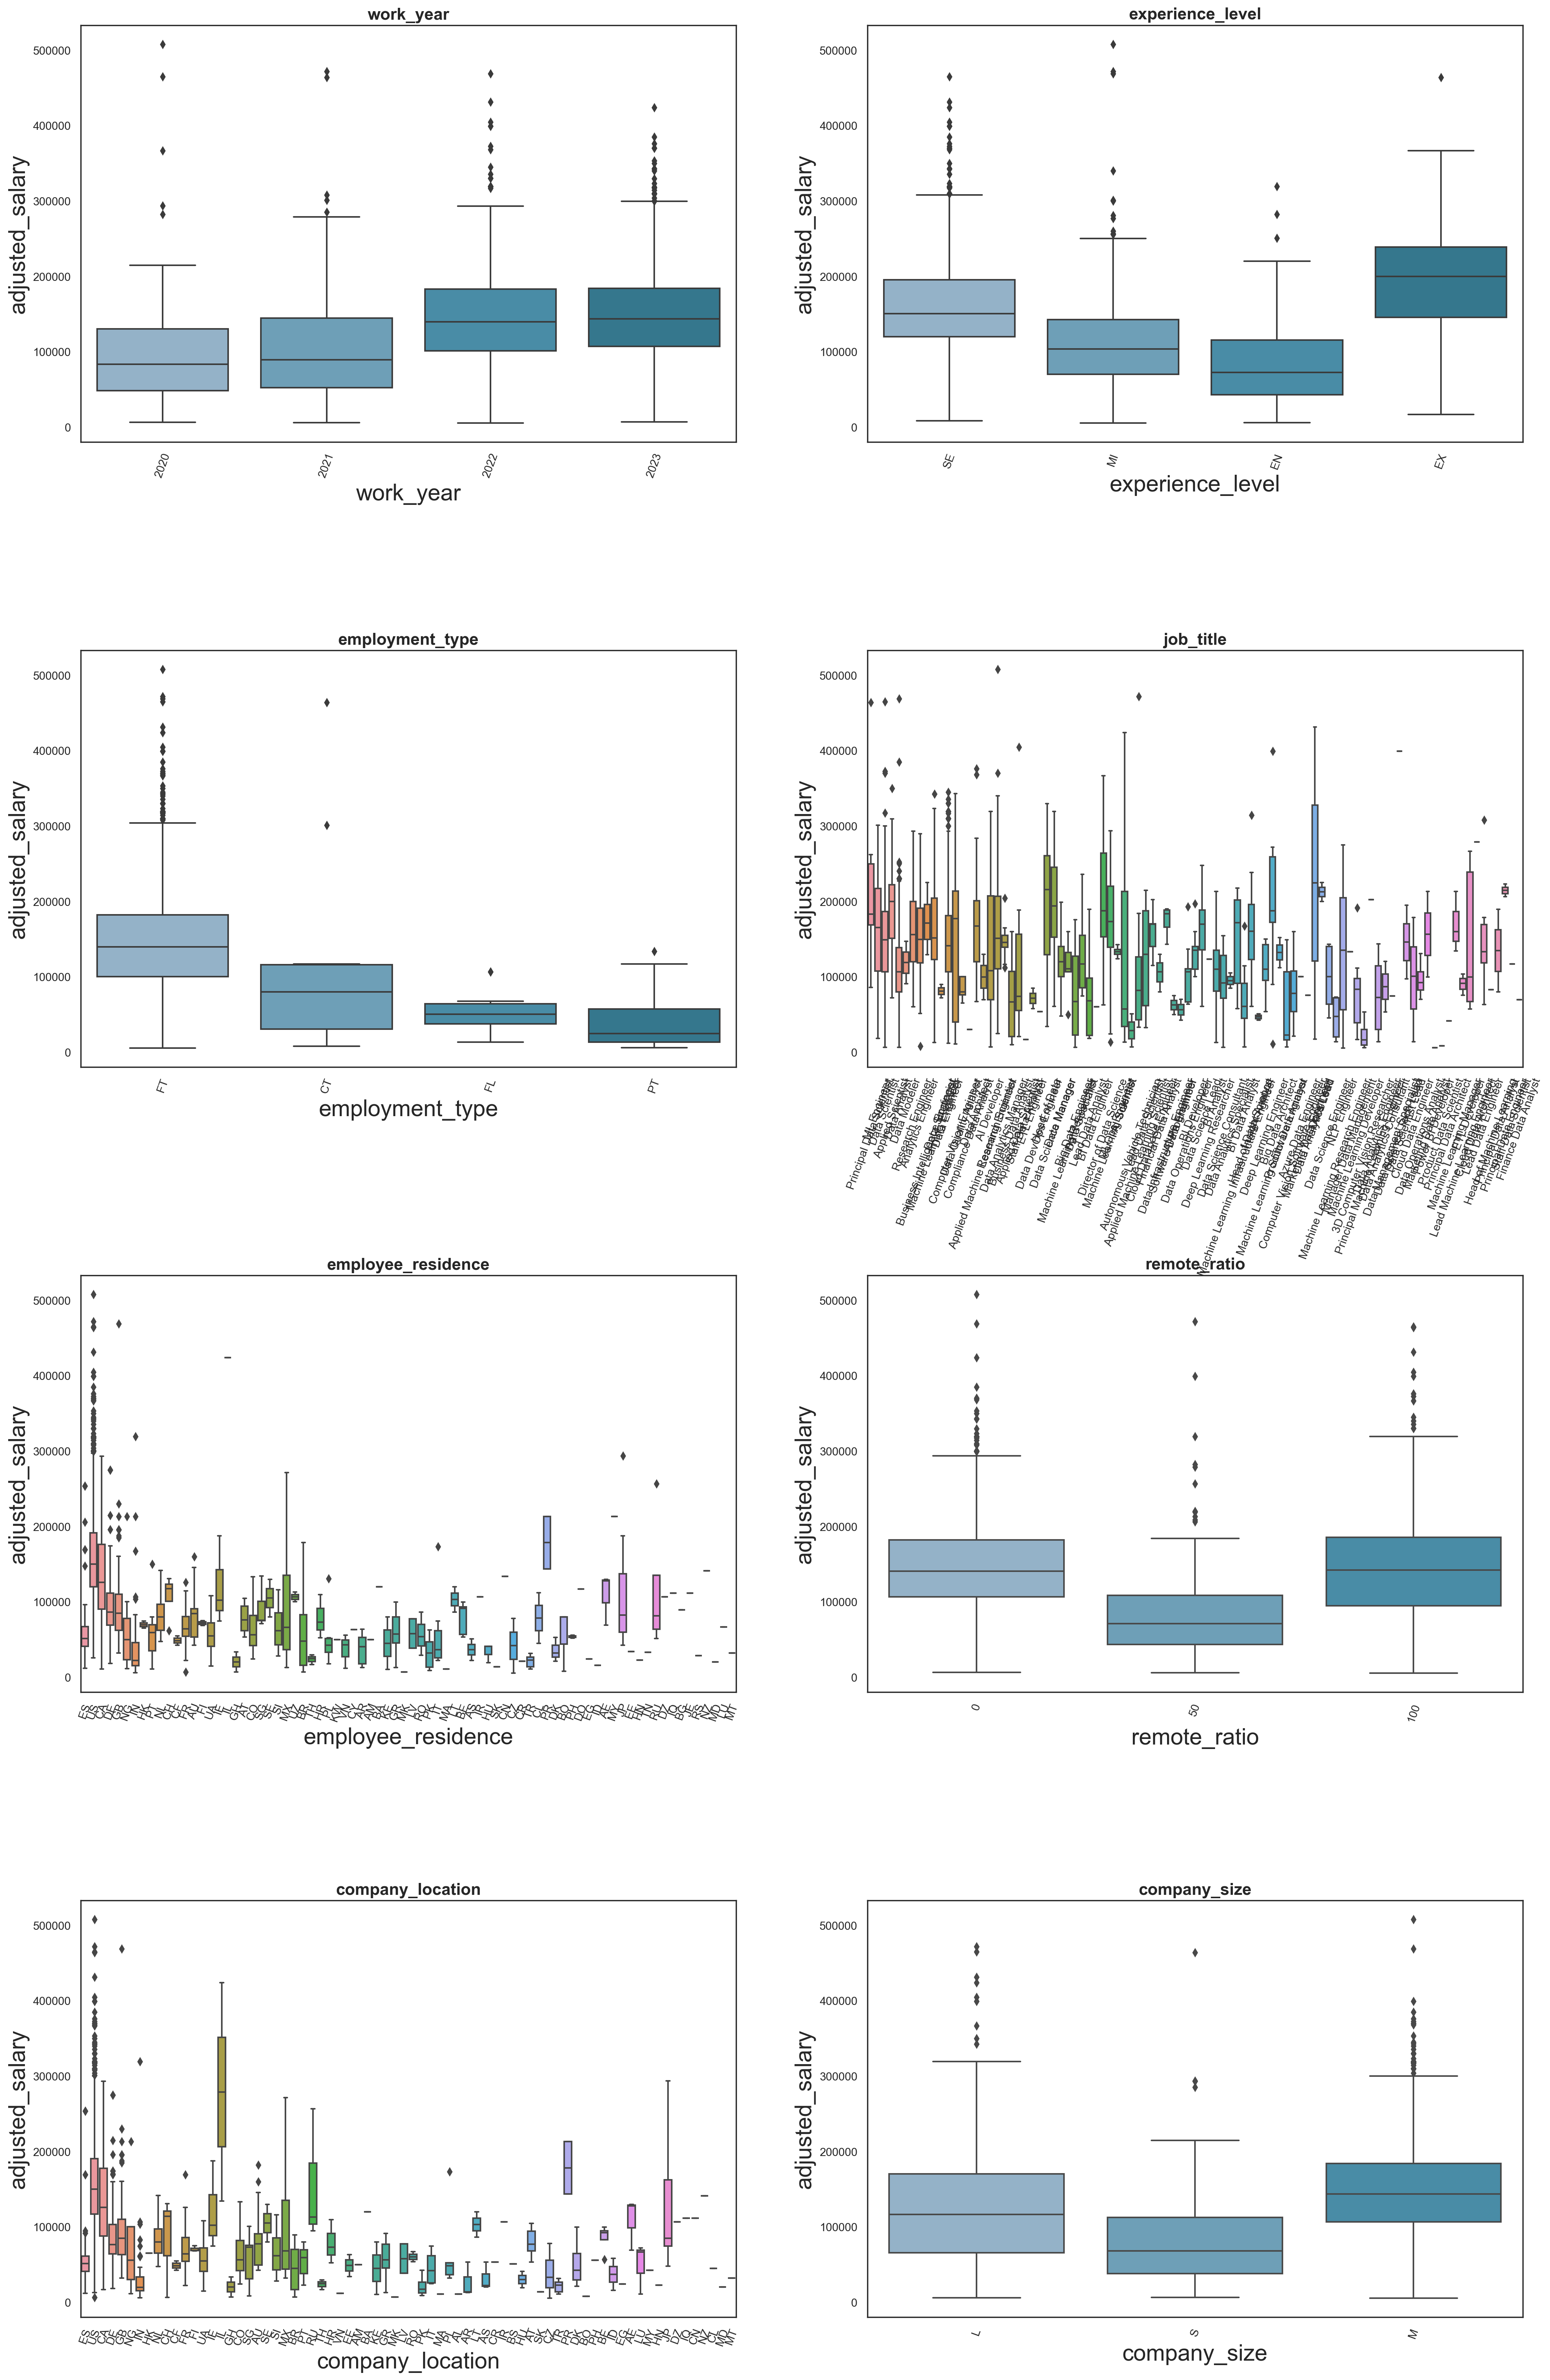

In [289]:
fig, axes = plt.subplots(4,2, figsize = (25,40), dpi=200)
plt.subplots_adjust(hspace=0.5)
columns = df_copy.columns[:-1]
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data = df_copy, x = column, y='adjusted_salary', ax = ax)
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 22)
    ax.set_ylabel('adjusted_salary', fontsize = 22)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=70, fontsize = 11)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 11)

Можно сделать вывод, что заработная платы зависит от всех категорий каждого признака, так как медианы каждой группы внутри признака различаются. Закодируем все признаки метками по каждой категории, где 0 будет соответвовать самой низкооплачиваемой категории, а максимальныя метка соответвенно самой высооплачиваемой категории.

In [290]:

# Вычисляем среднюю зарплату внутри каждого признака по категориям этого признака, сортируем полученные категории по возрастанию средней зарплаты, далее
# затем каждой категории ставим в соответствие метку от 0 до n-1 (количество прихнаков в категории). В данные добавляем колонку с закодированным признаком

for column in df_copy[columns]:
    df_column = pd.DataFrame(df_copy.groupby(by=column).adjusted_salary.mean().round(2)).sort_values(by='adjusted_salary')
    print('\n', df_column)
    column_index = list(df_column.index)
    df_copy[column+'_enc'] = df_copy[column].apply(lambda x: list(column_index).index(x))


            adjusted_salary
work_year                 
2020             104710.01
2021             105225.09
2022             142233.76
2023             149045.54

                   adjusted_salary
experience_level                 
EN                       82264.98
MI                      109339.57
SE                      157999.68
EX                      201865.45

                  adjusted_salary
employment_type                 
PT                      42872.47
FL                      55366.20
CT                     125127.00
FT                     143181.61

                                adjusted_salary
job_title                                     
Power BI Developer                     6090.00
Product Data Scientist                 8520.00
Staff Data Analyst                    16931.00
3D Computer Vision Researcher         23072.75
Autonomous Vehicle Technician         28898.00
...                                        ...
Principal Data Engineer              214648.00
Princ

In [291]:
df_copy.drop(columns, axis=1, inplace=True)
df_copy.T

0      1      2       3       4       5       6     \
adjusted_salary         85847  30000  25500  175000  120000  222200  136000   
work_year_enc               3      3      3       3       3       3       3   
experience_level_enc        2      1      1       2       2       2       2   
employment_type_enc         3      2      2       3       3       3       3   
job_title_enc              89     74     74      61      61      81      81   
employee_residence_enc     38     74     74      72      72      74      74   
remote_ratio_enc            1      1      1       1       1       2       2   
company_location_enc       39     69     69      66      66      69      69   
company_size_enc            1      0      0       2       2       1       1   

                          7       8       9     ...    3745    3746    3747  \
adjusted_salary         219000  141000  147100  ...  187329  134069  471668   
work_year_enc                3       3       3  ...       1       1       1   
experience_level_enc         2       2       2  ...       2       1       1   
employment_type_enc          3       3       3  ...       3       3       3   
job_title_enc               61      61      61  ...      86      61      45   
employee_residence_enc      72      72      74  ...      66      53      74   
remote_ratio_enc             2       2       2  ...       2       1       0   
company_location_enc        66      66      69  ...      65      71      69   
company_size_enc             2       2       2  ...       0       2       1   

                         3748    3749    3750    3751    3752    3753    3754  
adjusted_salary         31945  183984  465053  168373  118520  112877  106600  
work_year_enc               1       1       0       1       0       0       1  
experience_level_enc        1       2       2       1       0       0       2  
employment_type_enc         3       3       3       3       3       2       3  
job_title_enc              64      51      61      89      61      17      83  
employee_residence_enc     12      74      74      74      74      74      21  
remote_ratio_enc            0       1       1       1       1       1       0  
company_location_enc       15      69      69      69      69      69      17  
company_size_enc            1       1       1       1       0       1       1  

[9 rows x 3755 columns]

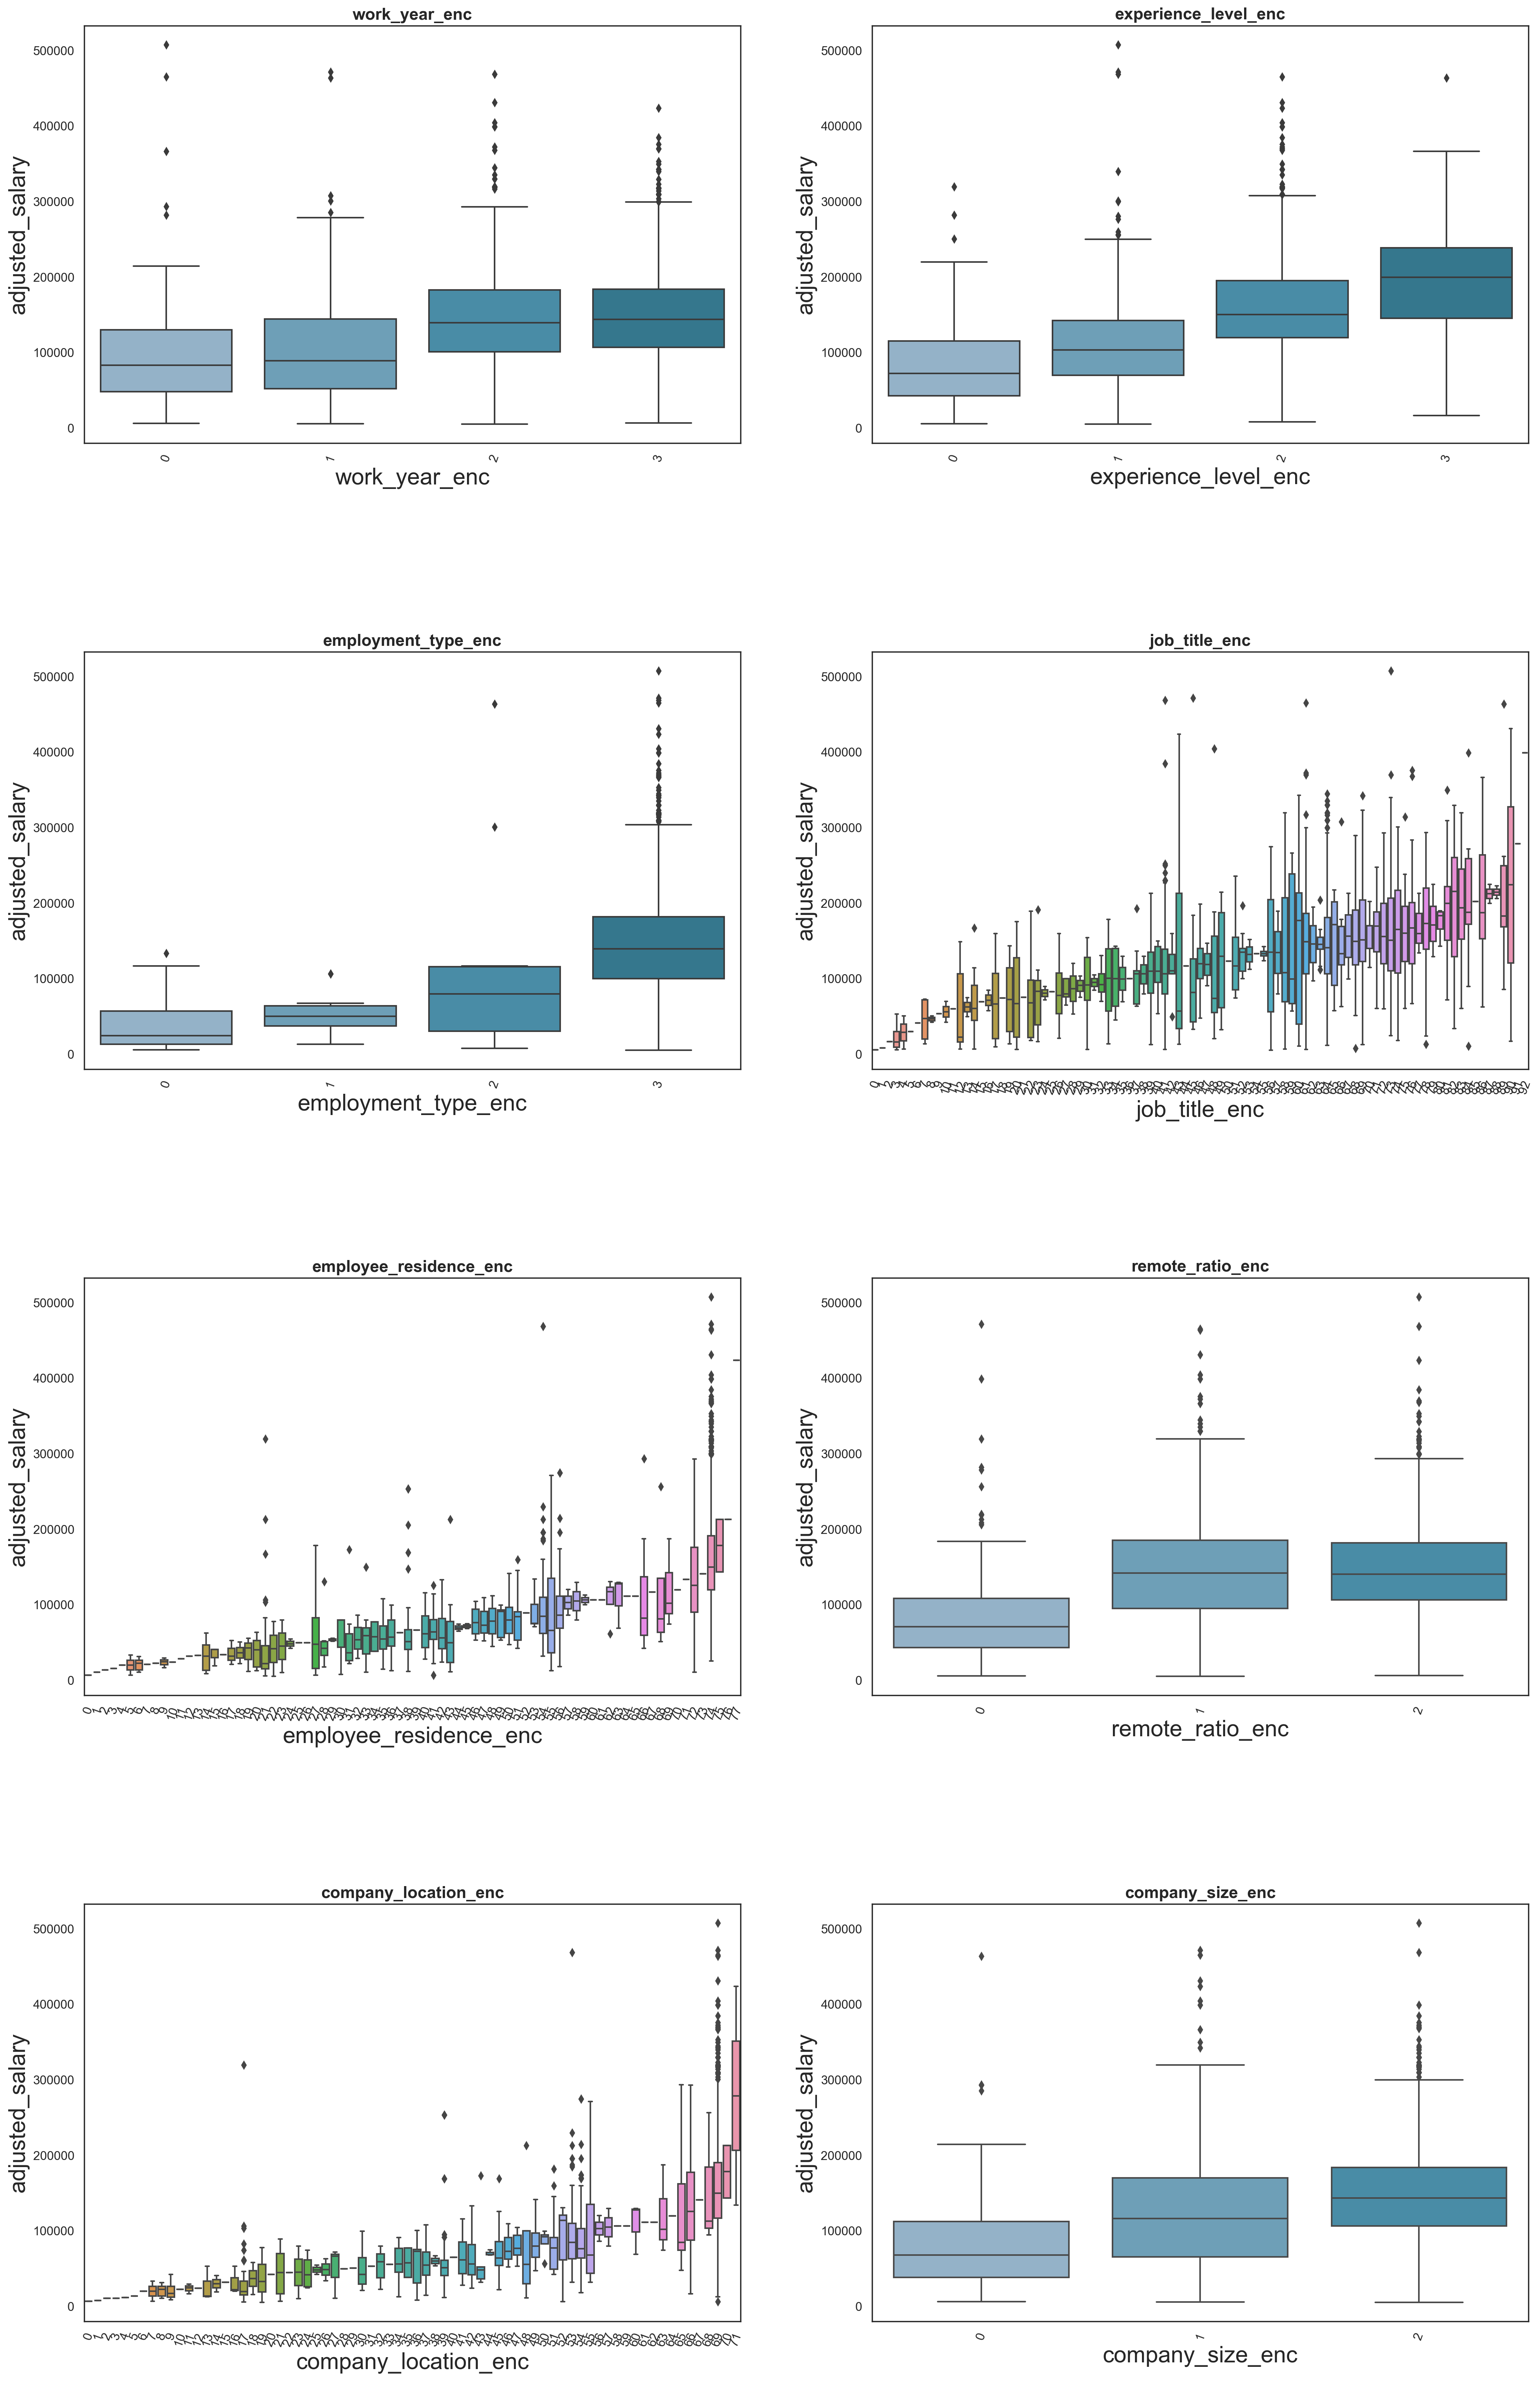

In [294]:
fig, axes = plt.subplots(4,2, figsize = (25,40), dpi=200)
plt.subplots_adjust(hspace=0.5)
columns = df_copy.columns[1:]
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data = df_copy, x = column, y='adjusted_salary', ax = ax)
    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 22)
    ax.set_ylabel('adjusted_salary', fontsize = 22)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=70, fontsize = 12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)

По графикам видим, что медианы внутри признаков растут, все правильно отсортировалось.
При обкчении на таком наборе признаков модель дает коэффициент детерминации 0,41. При введении любых доп признаков, связанных с зарплатой (как было на семинаре метрика combain_metriс, без нее r2 =0,3), качество модели резко растет, что и логично. Но правильно ли добавлять признаки напрямую коррелирующие с таргетом?

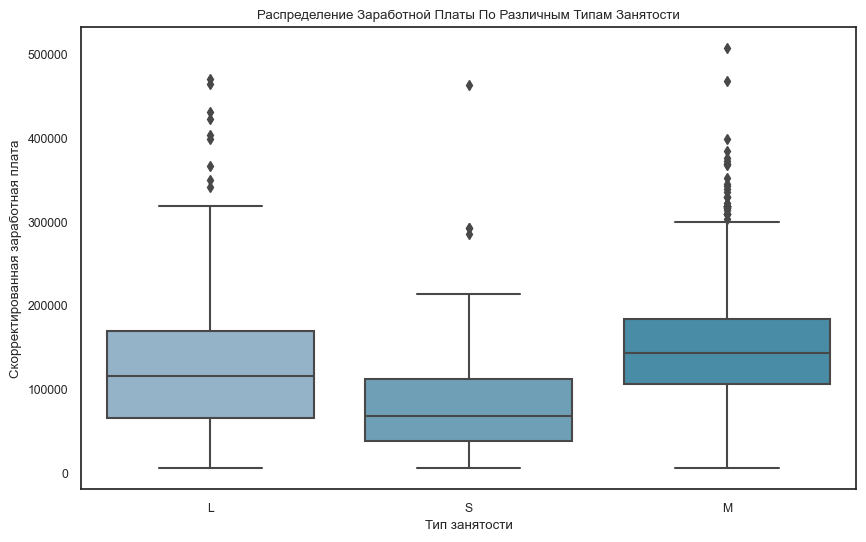

In [297]:
#Введем новый признак, комбинирующий в себе размер компании и мреднюю зарплату в этой категории компаний. Посмотрим, зависят ли они
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='company_size', y='adjusted_salary')
plt.title('Распределение Заработной Платы По Различным Типам Занятости')
plt.xlabel('Тип занятости')
plt.ylabel('Скорректированная заработная плата')
plt.show()

Можно предположить, что в средней компании платят зп выше чем в крупной, и в маленькой самую маленькую зп.

In [298]:
# Устанавливаем границы для категоризации зарплат
salary_bins = [df_copy['adjusted_salary'].min(),
               df_copy['adjusted_salary'].quantile(0.25),
               df_copy['adjusted_salary'].quantile(0.75),
               df_copy['adjusted_salary'].max()]
salary_labels = ['Low', 'Medium', 'High']
df_copy['salary_category'] = pd.cut(df_copy['adjusted_salary'], bins=salary_bins, labels=salary_labels, include_lowest=True)

# Создаем комбинированный признак
df_copy['size_conditions'] = df_copy['salary_category'].astype(str) + ' salary with ' + df['company_size'].astype(str)

df_copy.head()

adjusted_salary  work_year_enc  experience_level_enc  employment_type_enc  \
0            85847              3                     2                    3   
1            30000              3                     1                    2   
2            25500              3                     1                    2   
3           175000              3                     2                    3   
4           120000              3                     2                    3   

   job_title_enc  employee_residence_enc  remote_ratio_enc  \
0             89                      38                 1   
1             74                      74                 1   
2             74                      74                 1   
3             61                      72                 1   
4             61                      72                 1   

   company_location_enc  company_size_enc salary_category  \
0                    39                 1             Low   
1                    69                 0             Low   
2                    69                 0             Low   
3                    66                 2          Medium   
4                    66                 2          Medium   

        size_conditions  
0     Low salary with L  
1     Low salary with S  
2     Low salary with S  
3  Medium salary with M  
4  Medium salary with M

In [299]:
df_copy.size_conditions.value_counts()

size_conditions
Medium salary with M    1669
High salary with M       818
Low salary with M        666
Low salary with L        189
Medium salary with L     163
High salary with L       102
Low salary with S        101
Medium salary with S      34
High salary with S        13
Name: count, dtype: int64

In [300]:
size_index = pd.DataFrame(df_copy.groupby(by='size_conditions').adjusted_salary.mean()).sort_values(by='adjusted_salary')
size_index 

adjusted_salary
size_conditions                      
Low salary with S        50068.079208
Low salary with L        55569.751323
Low salary with M        70106.887387
Medium salary with S    127660.588235
Medium salary with L    136950.288344
Medium salary with M    140097.847214
High salary with M      225388.072127
High salary with L      241146.901961
High salary with S      244705.076923

In [301]:
df_copy['size_conditions_enc'] = df_copy.size_conditions.apply(lambda x: list(size_index.index).index(x))

In [302]:
df_copy.drop(['size_conditions', 'salary_category'], inplace=True, axis=1)

In [303]:
df_copy.head()

adjusted_salary  work_year_enc  experience_level_enc  employment_type_enc  \
0            85847              3                     2                    3   
1            30000              3                     1                    2   
2            25500              3                     1                    2   
3           175000              3                     2                    3   
4           120000              3                     2                    3   

   job_title_enc  employee_residence_enc  remote_ratio_enc  \
0             89                      38                 1   
1             74                      74                 1   
2             74                      74                 1   
3             61                      72                 1   
4             61                      72                 1   

   company_location_enc  company_size_enc  size_conditions_enc  
0                    39                 1                    1  
1                    69                 0                    0  
2                    69                 0                    0  
3                    66                 2                    5  
4                    66                 2                    5

In [98]:
#Признаки employee_residence, company_location  закодируем по частоте встречаемости
# Вычисляем количество встречаемости каждого уникального значения в колонке
for column in df_copy[['employee_residence', 'company_location', 'company_size']]:
    column_index = list(pd.DataFrame(df_copy.groupby(by=column).adjusted_salary.mean()).sort_values(by='adjusted_salary').index)

    #Закодируем 'company_location' на основе количества встречаемости
    df_copy[column+'_enc'] = df_copy[column].apply(lambda x: list(column_index).index(x))
    
df_copy.drop(['job_title', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size'], axis=1, inplace=True)

In [99]:
df_copy.head()

adjusted_salary  work_year_enc  remote_ratio_enc  experience_level_enc  \
0            85847              0                 1                     2   
1            30000              0                 1                     1   
2            25500              0                 1                     1   
3           175000              0                 1                     2   
4           120000              0                 1                     2   

   employment_type_enc  job_title_enc  employee_residence_enc  \
0                    3             89                      38   
1                    2             74                      74   
2                    2             74                      74   
3                    3             61                      72   
4                    3             61                      72   

   company_location_enc  company_size_enc  
0                    39                 1  
1                    69                 0  
2                    69                 0  
3                    66                 2  
4                    66                 2

Посмотрим корреляцию между заработной платой и всеми нашими признаками.

In [304]:
df_copy['adjusted_salary']=df_copy.adjusted_salary
corr =df_copy.corr(method='spearman')
target_corr = corr['adjusted_salary'].drop('adjusted_salary')
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Корреляция с заработной платой')
plt.show()

## Наиболее значимые положительные корреляции:
1. size_conditions_enc (0.90)
2. employee_residence_enc (0.52) 
3. company_location_enc (0.50) 
4. experience_level_enc (0.45) 
5. job_title_enc (0,34)

In [305]:
target_corr = corr['employee_residence_enc'].drop('employee_residence_enc')
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Корреляция с employee_residence_enc')
plt.show()

Корреляция между employee_residence_enc и company_location_enc составляет 95%, в дальнейшем посмотрим, может быть от одного из признаков избавимся.

## 2. Построение модели линейной регрессии:
— Разделить данные на обучающую и тестовую выборки.
— Построить модель линейной регрессии для прогнозирования заработной платы.
— Оценить качество модели с помощью метрик MAE, MSE и R-квадрат.
— Проанализировать значимость признаков и мультиколлинеарность.

In [306]:
df_copy.head()

adjusted_salary  work_year_enc  experience_level_enc  employment_type_enc  \
0            85847              3                     2                    3   
1            30000              3                     1                    2   
2            25500              3                     1                    2   
3           175000              3                     2                    3   
4           120000              3                     2                    3   

   job_title_enc  employee_residence_enc  remote_ratio_enc  \
0             89                      38                 1   
1             74                      74                 1   
2             74                      74                 1   
3             61                      72                 1   
4             61                      72                 1   

   company_location_enc  company_size_enc  size_conditions_enc  
0                    39                 1                    1  
1                    69                 0                    0  
2                    69                 0                    0  
3                    66                 2                    5  
4                    66                 2                    5

Разделение на обучающую и тестовую выборки

In [313]:
#Проведем стандартизацию признаков job_title_enc	employee_residence_enc	company_location_enc	company_size_enc	adjusted_salary
scaler = StandardScaler()
scaled_df=pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
scaled_df.head()

adjusted_salary  work_year_enc  experience_level_enc  employment_type_enc  \
0        -0.874879       0.905994              0.522637             0.093177   
1        -1.738140       0.905994             -0.951820            -4.226329   
2        -1.807700       0.905994             -0.951820            -4.226329   
3         0.503214       0.905994              0.522637             0.093177   
4        -0.346955       0.905994              0.522637             0.093177   

   job_title_enc  employee_residence_enc  remote_ratio_enc  \
0       2.171588               -2.200077         -0.781446   
1       1.076785                0.414324         -0.781446   
2       1.076785                0.414324         -0.781446   
3       0.127955                0.269079         -0.781446   
4       0.127955                0.269079         -0.781446   

   company_location_enc  company_size_enc  size_conditions_enc  
0             -2.166809         -1.638088            -1.906641  
1              0.388957         -3.685016            -2.475257  
2              0.388957         -3.685016            -2.475257  
3              0.133381          0.408840             0.367821  
4              0.133381          0.408840             0.367821

In [314]:
X = scaled_df.drop(["adjusted_salary"], axis=1)
y = scaled_df["adjusted_salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print(f'MSE_train: {mean_squared_error(y_train, y_train_pred).round(2)},\
\nMAE_train :{mean_absolute_error( y_train, y_train_pred).round(2)},\
\nR2_train: {r2_score(y_train, y_train_pred).round(2)}')
print(f'MSE_test: {mean_squared_error( y_test, y_test_pred).round(2)},\
\nMAE_test :{mean_absolute_error( y_test, y_test_pred).round(2)},\
\nR2_test: {r2_score(y_test, y_test_pred).round(2)}')

MSE_train: 0.29,
MAE_train :0.38,
R2_train: 0.71
MSE_test: 0.29,
MAE_test :0.4,
R2_test: 0.71


Результаты на обучающей выборке:   MSE_train: 0.29,
MAE_train :0.38,
R2_train: 0.71., на тестовой выборMSE_test: 0.29,
MAE_test :0.4,
R2_test: 0.71зания.

In [316]:
#Попробуем убрать признак employee_residence_enc так как он коррелирует с company_location_enc и еще раз обучить модель
X = scaled_df.drop(["adjusted_salary"], axis=1)
y = scaled_df["adjusted_salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print(f'MSE_train: {mean_squared_error(y_train, y_train_pred).round(2)},\
\nMAE_train :{mean_absolute_error( y_train, y_train_pred).round(2)},\
\nR2_train: {r2_score(y_train, y_train_pred).round(2)}')
print(f'MSE_test: {mean_squared_error( y_test, y_test_pred).round(2)},\
\nMAE_test :{mean_absolute_error( y_test, y_test_pred).round(2)},\
\nR2_test: {r2_score(y_test, y_test_pred).round(2)}')

MSE_train: 0.29,
MAE_train :0.38,
R2_train: 0.71
MSE_test: 0.29,
MAE_test :0.4,
R2_test: 0.71


Результаты остались прежними, колинеарность этих двух признаков не повлияла на результута обучения модели.

### 3. Построение модели дерева решений:
— Построить модель дерева решений для прогнозирования заработной платы.
— Оценить качество модели с помощью метрик RMSE и R-квадрат.
— Подберите гиперпараметры для модели дерево решений
— Визуализировать дерево решений.

In [317]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [320]:
# Прогноз и оценка качества модели
y_tree_pred = tree_model.predict(X_test)
rmse = mean_squared_error(y_test, y_tree_pred, squared=False).round(2)
r2_tree= r2_score(y_test, y_tree_pred).round(2)

print(f'RMSE_test: {rmse}, R²_test: {r2_tree}')

RMSE_test: 0.49, R²_test: 0.76


In [321]:
# Подбор гиперпараметров
param_grid = {'max_depth': [3, 4, 5, 6, 7], 'min_samples_split': [5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Лучшие параметры:', grid_search.best_params_)

Лучшие параметры: {'max_depth': 4, 'min_samples_split': 6}


In [322]:
tree_model = DecisionTreeRegressor(random_state=42, max_depth =4, min_samples_split= 6)
tree_model.fit(X_train, y_train)
y_tree_pred = tree_model.predict(X_test)
rmse = mean_squared_error(y_test, y_tree_pred, squared=False).round(2)
r2_tree = r2_score(y_test, y_tree_pred).round(2)

print(f'RMSE_test: {rmse}, R²_test: {r2_tree}')

RMSE_test: 0.43, R²_test: 0.81


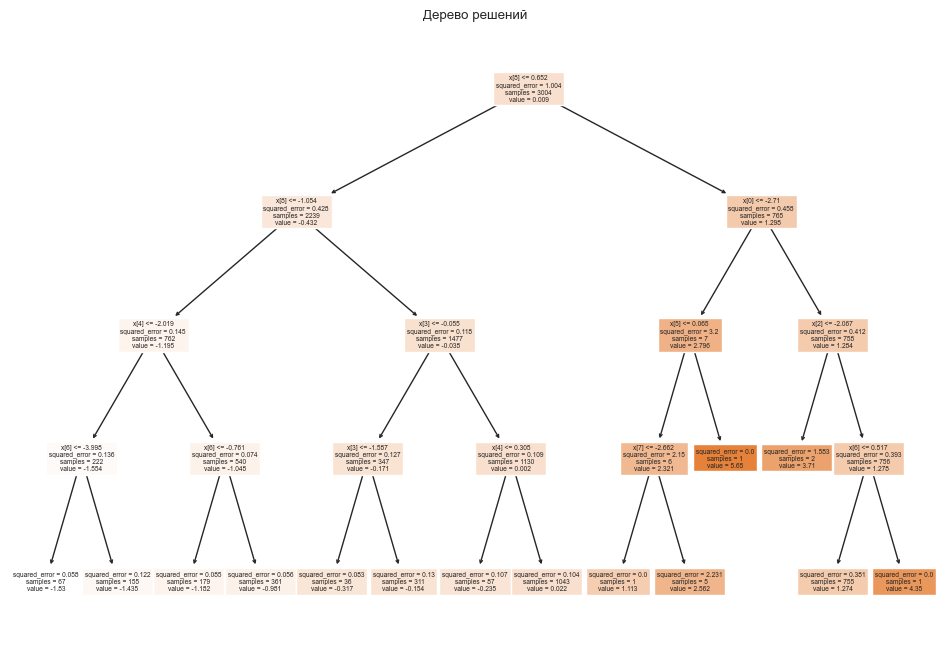

In [323]:
# Визуализация дерева
plt.figure(figsize=(12, 8))
plot_tree(grid_search.best_estimator_, filled=True)
plt.title("Дерево решений")
plt.show()

Лучшие параметры модели при значениях {'max_depth': 4, 'min_samples_split':6}. Коэффициент детерминации с лучшими параметрами достиг 0,81.

### 4. Построение ансамблевой модели:
— Построить ансамблевую модель, используя Random Forest и Boosting.
— Сравнить качество ансамблевой модели с отдельными моделями.
— Оценить важность признаков в ансамблевой модели.

In [324]:
# Модель Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_rf_pred).round(2)

In [325]:
# Модель Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_gb_pred = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, y_gb_pred).round(2)

In [326]:
print(f'Random Forest R²: {rf_r2}, Gradient Boosting R²: {gb_r2}')

Random Forest R²: 0.82, Gradient Boosting R²: 0.83


Метрика R² у ансамблевых моделей немного улучшилась на 1-2% по сравнению с деревом решений.

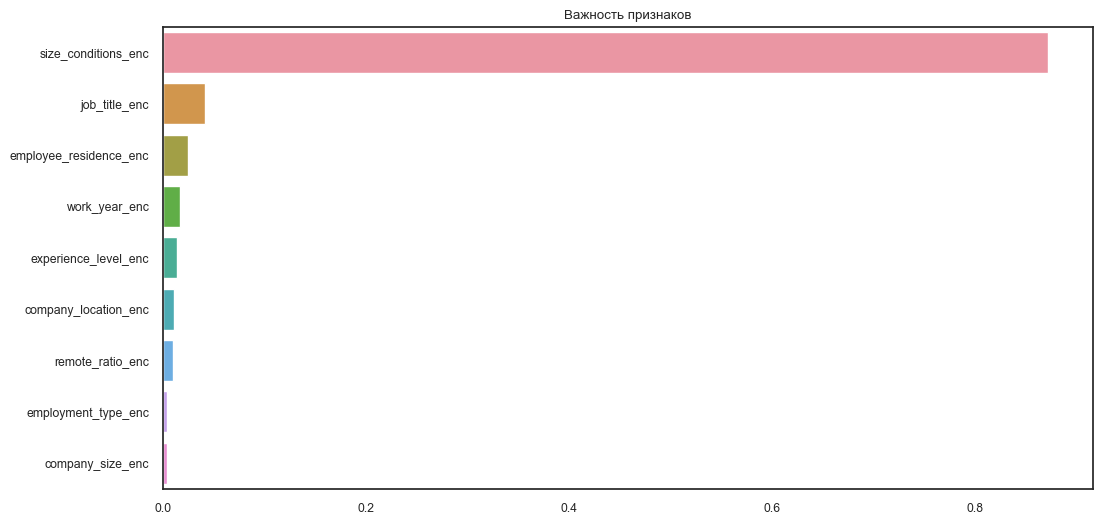

In [327]:
# Оценка важности признаков
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Важность признаков")
plt.show()

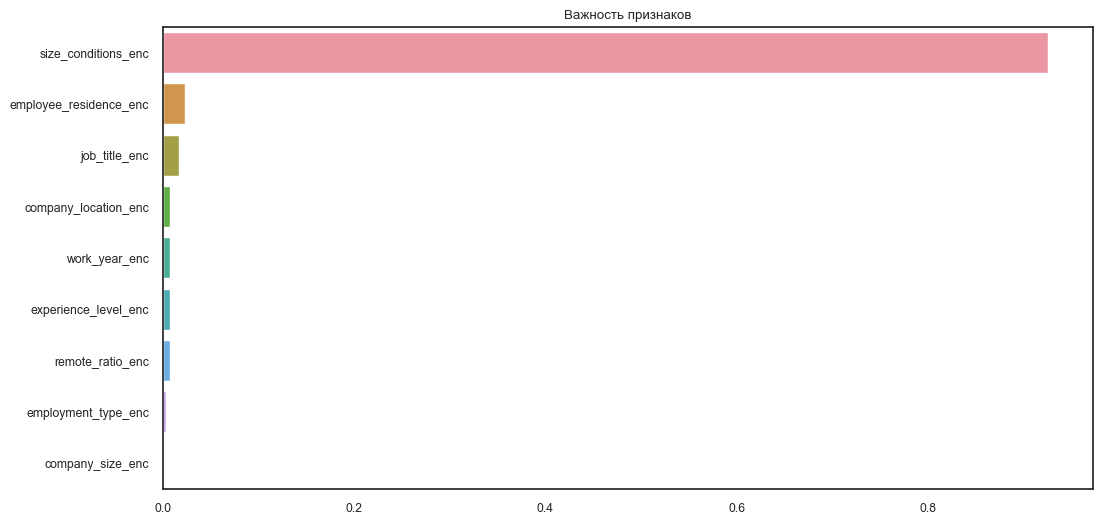

In [328]:
# Оценка важности признаков
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Важность признаков")
plt.show()

Как и можно было предположить, признак 'size_conditions_enc' оказываtn наибольшее влияние на уровень заработной платы, далее идут 'employee_residence_enc', 'job_title_enc' и 'remote_ratio' оказывают наибольшее влияние на уровень заработной платы.

### 5. Понижение размерности:
— Применить Principal Component Analysis (PCA) для снижения размерности данных.
— Построить модель линейной регрессии с использованием данных, полученных после PCA.
— Сравнить качество модели с использованием исходных данных.

Метод главных компонент может быть полезен в задаче классификации при большом количестве признаков, так как значительно улучшает результаты работы ансамблевых методов. Однако в данном случае решается задача кластеризации, поэтому он будет использоваться только для упрощения восприятия данных в виде двумерного и трехмерного графиков.

In [385]:
pca = PCA(random_state=42)  # сохраняем 95% дисперсии
pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.37822139 0.13325268 0.11121287 0.10082685 0.08432555 0.07463068
 0.06451286 0.04374466 0.00927246]


In [386]:
pca.explained_variance_ratio_[:6].sum()

0.88247002151147

In [388]:
#Для сохранения от 88% дисперсии нужно использовать минимум 5 компонент)
pca = PCA(n_components=6, random_state=42)  # сохраняем 95% дисперсии
X_pca = pca.fit_transform(X)

In [389]:
# Модель линейной регрессии с использованием PCA
X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.2, random_state=42)
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

LinearRegression()

In [391]:
y_pca_pred = model_pca.predict(X_test_pca)
pca_mae = mean_absolute_error(y_test, y_pca_pred).round(2)
pca_mse = mean_squared_error(y_test, y_pca_pred).round(2)
pca_r2 = r2_score(y_test, y_pca_pred).round(2)

print(f'PCA MAE: {pca_mae}, PCA MSE: {pca_mse}, PCA R²: {pca_r2}')

PCA MAE: 0.51, PCA MSE: 0.44, PCA R²: 0.55


После понижения размерности данных c использованием РСА метрики MAE выросла в 2 раза, MSE практически не изменились. А метрика R² понизилась с 0,71 до 0,55. Применение алгоритма РСА не улучшило качество модели линейной регрессии, скорее это связано с отсутствием линейной связи между входящими признаками.

### 6. Кластеризация:
— Применить метод K-Means для кластеризации данных по заработной плате.
— Определить оптимальное количество кластеров.
— Проанализировать характеристики полученных кластеров.
— Визуализировать результаты кластеризации и проанализировать характеристики в каждом кластере.
— Проанализируйте полученные данные и сделайте выводы о том, какой алгоритм кластеризации сможет выделить кластеры лучше, чем K-Means.

In [543]:
principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                s=60)

plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

1 183.83416439824234
2 155.83935372803185
3 147.53039783679577
4 135.78734579350382
5 128.3636379677057
6 121.70727388669326
7 117.52486072183689
8 113.23188270366204
9 109.65797201380708


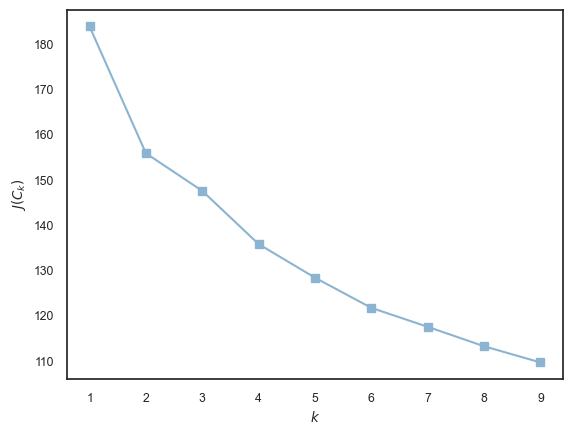

In [526]:

#Примерно можно выделить 6 кластеров, посмотрим оптимальное количество кластеров методом локтя
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    print(k, np.sqrt(kmeans.inertia_))
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 10), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

In [604]:
#Возьмем количество кластеров равное 7.
pca = PCA(n_components=2)

kmeans = KMeans(n_clusters=7, random_state=42, n_init='auto').fit(X)
centroids_pca = pca.fit_transform(kmeans.cluster_centers_)
pred_k = kmeans.labels_

principal_df = pd.DataFrame(data = PCA(n_components=2).fit_transform(X))

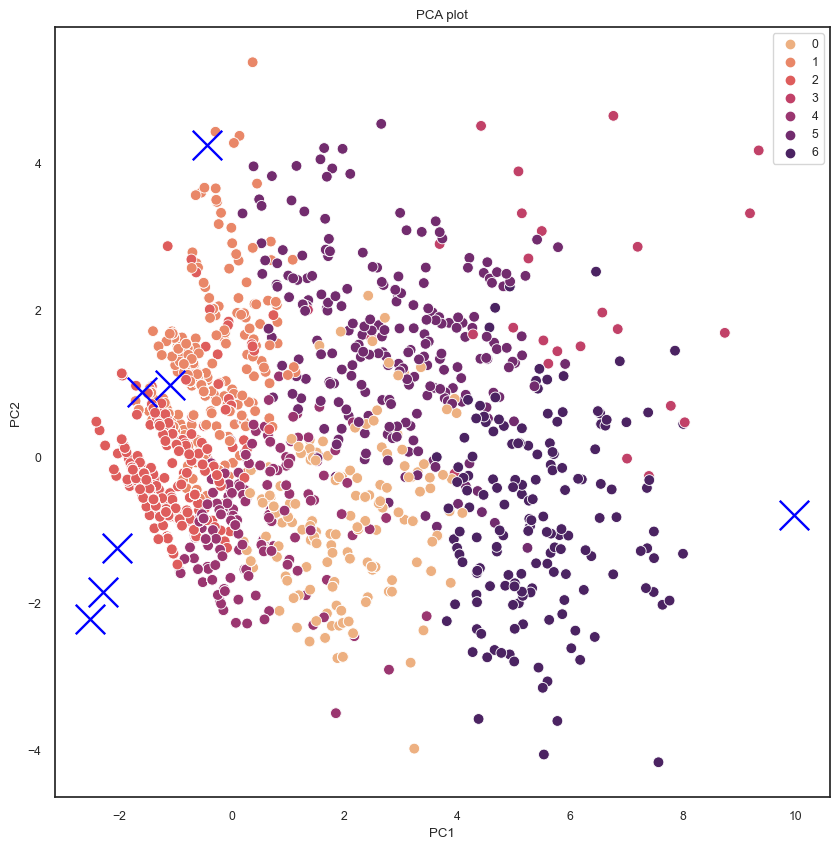

In [605]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_k,
                palette="flare",
                s=60)
sns.scatterplot(x = centroids_pca[:,0],
                y =  centroids_pca[:,1],
                marker="x",
                s=450,
                color = 'blue')
plt.title('PCA plot')
plt.xlabel('PC1')
plt.ylabel('PC2');

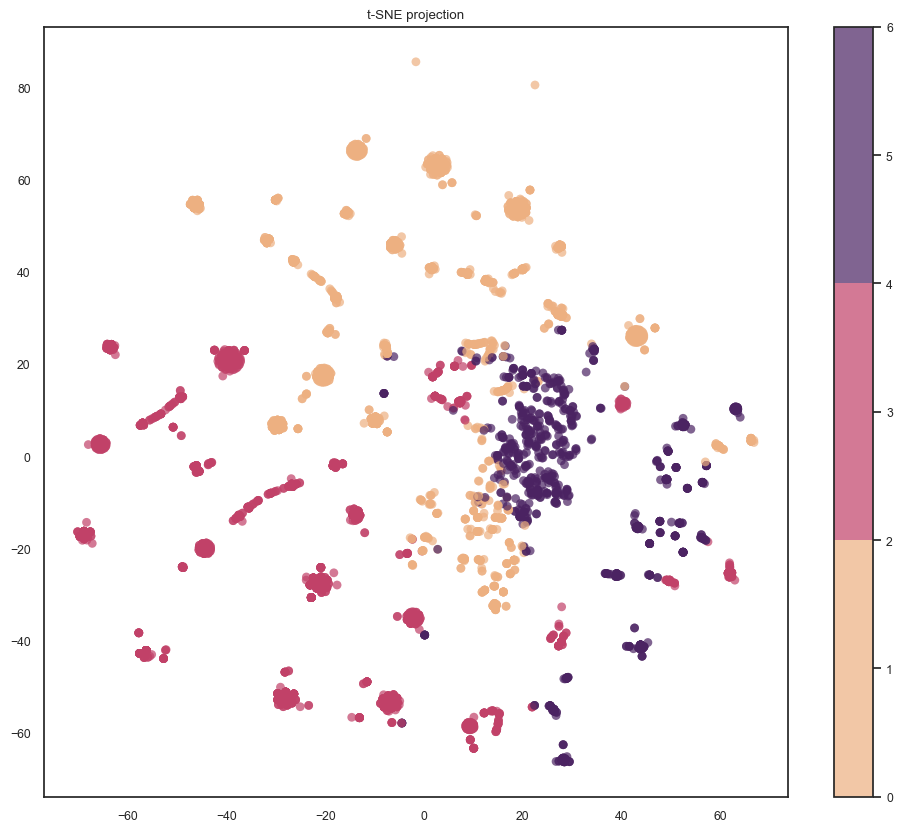

In [606]:
#Посмотрим на кластеризацию t-SNE
def TSNEplot(pred=None):
    tsne = TSNE(random_state=42)

    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(12, 10))
    plt.scatter(X_tsne[:, 0],
                X_tsne[:, 1],
                c = pred,
                edgecolor="none",
                alpha=0.7, s=40,
        cmap=plt.cm.get_cmap("flare", 3))

    plt.colorbar()
    plt.title("t-SNE projection");
    
TSNEplot(pred_k)

In [607]:
def PCAplot3D(x_data, y_data=None):
    components = PCA(n_components=3).fit_transform(X)

    fig = px.scatter_3d(
        components,
        x=0, y=1, z=2,
        color=y_data,
        size=0.1*np.ones(len(X)),
        opacity = 1,
        title='PCA plot in 3D',
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        width=900, height=900
    )
    fig.show()

PCAplot3D(df_copy, pred_k)

silhouette - оценка сходства между объектами внутри одного кластера и различия между кластерами,то есть,  на сколько близки объекты в одном кластере (среднее расстояние от объекта до других объектов в этом же кластере (значение a в формуле) и среднее расстояние от объекта до других объектов в других кластерах (значение b в формуле) по отношению к максимальному числу среди данных двух чисел)
    
variance ration criterion - отношение межкластерной дисперсии (сумма квадратов расстояний между центроидами кластеров и общим центроидом) и отношение внутрикластерной дисперсии (сумма квадратов расстояний от каждой точки до своего центроида кластера)

In [608]:
silhouette = silhouette_score(X, pred_k)
chi = calinski_harabasz_score(X, pred_k)
print('\nK-Means')
print('_'*45 + '\n')
print('Силуэт', round(silhouette,3))
print('Variance Rarion Criterion', round(chi,3))
rs_k = rand_score(kmeans.labels_, y)
print("rand_score = {} \n\n {} из 3755 предсказано верно \n".format(rs_k, rs_k * 3755))


K-Means
_____________________________________________

Силуэт 0.253
Variance Rarion Criterion 903.748
rand_score = 0.7392469071605468 

 2775.872136387853 из 3755 предсказано верно 



Значение силуэта 0,253 указывает на умеренную кластеризацию. Это значит, что кластеры имеют перекрытия. При увеличении количества кластеров силуэт приближается к 0,3. Variance Rarion Criterion 903.748 указывает на умеренную дисперсию кластеров. Это значит, что кластеры достаточно компактны. Rand Score 0,74 говорит о том, что 74% объекта правильно предсказаны кластерами. 

### Построим распределения по каждому кластеру

In [609]:
df_cluster = df_copy.copy()
df_cluster['K-Means'] = pred_k

In [610]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(4,2, figsize = (25,40), dpi=200)

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = processed_df_copy.columns[:-1]

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df_cluster,
                x = column,
                fill = True,
                alpha = 0.8,
                hue = 'K-Means',
                ax = ax)

    ax.set_title(column, fontweight = 'bold', fontsize = 16)
    ax.set_xlabel(column, fontsize = 22)
    ax.set_ylabel('Плотность', fontsize = 22)

Графики подтверждают перекрытие кластеров по всем признакам. Так как кластеров много и они перекрываются, K-Means не лучший способ кластеризации в данном случае. Посмотрим другие варианты.

## Agglomerative Clustering by Ward

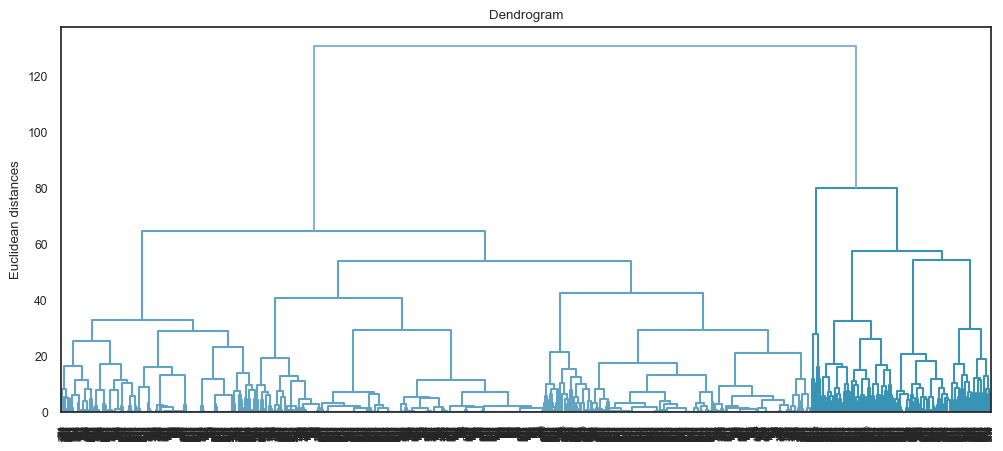

In [558]:
from matplotlib import pyplot
pyplot.figure(figsize=(12, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

In [598]:
clustering_ward = AgglomerativeClustering(7).fit(X)
pred_ward = clustering_ward.labels_

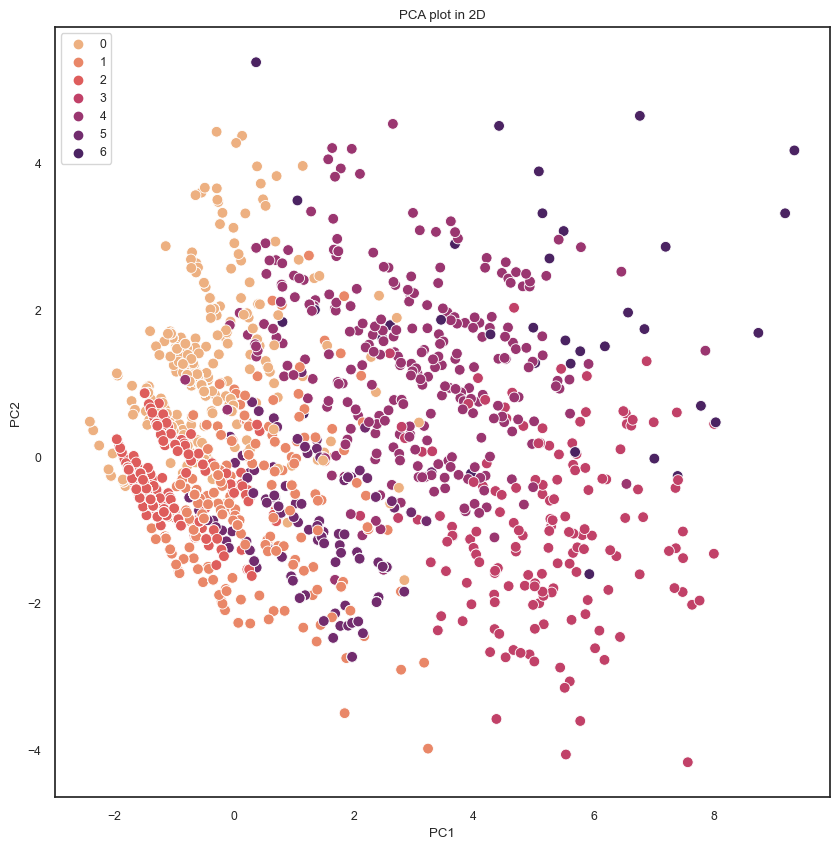

In [599]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_ward,
                palette="flare",
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [600]:
silhouette = silhouette_score(processed_df_copy, pred_ward)
chi = calinski_harabasz_score(processed_df_copy, pred_ward)
print('Agglomerative Clustering')
print('_'*45 + '\n')
print('Силуэт', round(silhouette,3))
print('Variance Rarion Criterion', round(chi,3))
rs_ward = rand_score(pred_ward, y)
print("rand_score = {} \n\n{} из 3755 предсказано верно \n".format(rs_ward, rs_ward * 3755))

Agglomerative Clustering
_____________________________________________

Силуэт 0.191
Variance Rarion Criterion 569.75
rand_score = 0.7652932300530566 

2873.6760788492275 из 3755 предсказано верно 



In [582]:
df_cluster['Agglomerative'] = pred_ward

## Spectral Clustering

In [570]:
clustering_sp = SpectralClustering(6).fit(X)
pred_sp = clustering_sp.labels_

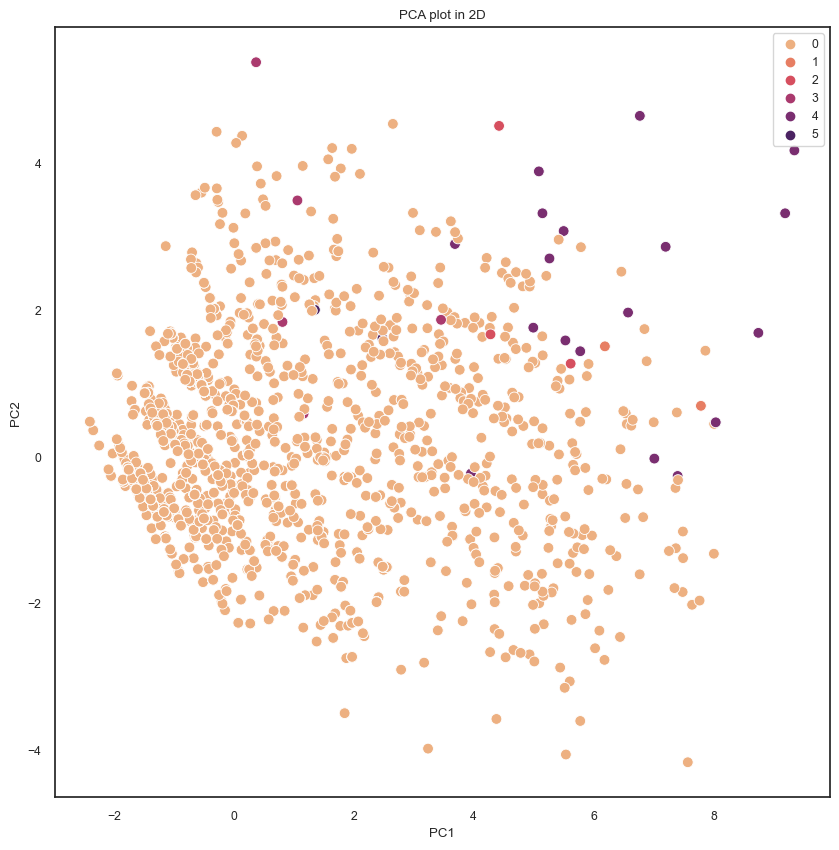

In [571]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_sp,
                palette="flare",
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [572]:
silhouette = silhouette_score(X, pred_sp)
chi = calinski_harabasz_score(X, pred_sp)
print('Spectral Clustering')
print('_'*45 + '\n')
print('Силуэт', round(silhouette,3))
print('Variance Rarion Criterion', round(chi,3))
rs_sp = rand_score(pred_sp, y)
print("rand_score = {} \n\n{} из 3755 предсказано верно \n".format(rs_sp, rs_sp * 3755))

Spectral Clustering
_____________________________________________

Силуэт 0.465
Variance Rarion Criterion 104.653
rand_score = 0.019499058970919258 

73.21896643580182 из 3755 предсказано верно 



Предсказательная способность практически нулевая, силуэт улучшился до 0,465 

In [573]:
df_cluster['Spectral'] = pred_sp

## DBSCAN

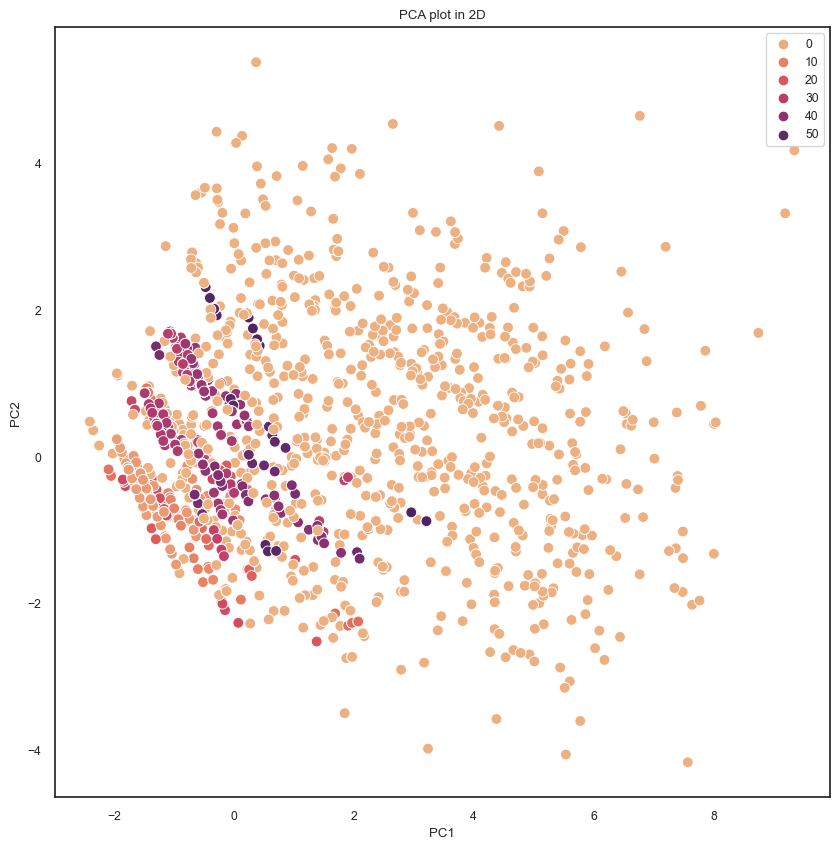

In [574]:
from sklearn.cluster import DBSCAN
clustering_db = DBSCAN(eps=0.5, min_samples=10).fit(X)
pred_db = clustering_db.labels_
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = principal_df.iloc[:,0],
                y = principal_df.iloc[:,1],
                hue = pred_db,
                palette="flare",
                s=60)
plt.title('PCA plot in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

In [577]:
PCAplot3D(X, pred_db)

In [575]:
silhouette = silhouette_score(X, pred_db)
chi = calinski_harabasz_score(X, pred_db)
print('DBSCAN')
print('_'*45 + '\n')
print('Силуэт', round(silhouette,3))
print('Variance Rarion Criterion', round(chi,3))
rs_db = rand_score(pred_db, y)
print("rand_score = {} \n\n{} из 3755 предсказано верно \n".format(rs_db, rs_db * 3755))

DBSCAN
_____________________________________________

Силуэт 0.277
Variance Rarion Criterion 50.679
rand_score = 0.8954154538753869 

3362.285029302078 из 3755 предсказано верно 



In [576]:
df_cluster['DBSCAN'] = pred_db

Предсказательная способность DBSCAN составяляет 89%, силуэт тоже лучше чем для PCA.

In [586]:
df_cluster[['K-Means','Agglomerative', 'Spectral', 'DBSCAN']]

K-Means  Agglomerative  Spectral  DBSCAN
0           0              4         0      -1
1           5              2         0      -1
2           5              2         0      -1
3           1              0         0       0
4           1              0         0       0
...       ...            ...       ...     ...
3750        1              0         0      -1
3751        5              4         0      -1
3752        5              4         0      -1
3753        5              2         3      -1
3754        0              3         0      -1

[3755 rows x 4 columns]

In [595]:
df_cluster['DBSCAN'].unique().shape

(58,)

Лучше всех алгоритмов кластеризации показал себя DBSCAN, но он выделил 58 кластеров, порядок количества кластеров похож на количество стран в которых расположены компании. В других алгоритмах также наблюдается зависимость, чем больше кластеров тем лучше точность. У того же 
K-Mean при 58 кластерах результат даже лучше, 

Силуэт 0, 418
Variance Rarion Criterion 36, .432
rand_score = 0.9576561742. Но плюс DBSCAN в том, что он сам определяет количество кластеров.29158 